# For plotting statistics from the lab analysis only

This notebook should be self contained, you may need to change the `DATA_PATH` if running locally so it can find the data tables.

In [1]:
SAVE = False

In [2]:
import csv
import sys

import os
import os.path as osp

import glob

import numpy as np

# for comparing predictions to lab analysis data frames
import pandas as pd

# for plotting
import matplotlib
# enable LaTeX style fonts
matplotlib.rc('text', usetex=True)
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# evaluation metrics
from sklearn.metrics import r2_score

from plot_utils import *

IN_COLAB = 'google.colab' in sys.modules

In [3]:
'''
root_path = '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/Lab/done/'
jpeg_files = glob.glob(root_path + '*.jpg')
jpeg_files.sort()
# Should equal 40
print(len(jpeg_files)) 

csvfile = 'lab-v100-originals-files.csv'

with open(csvfile, 'w') as f:
    csvwriter = csv.writer(f, delimiter=',')#, #escapechar='', quoting=csv.QUOTE_NONE)
    for i in range(len(jpeg_files)):
        csvwriter.writerow([jpeg_files[i].split('/')[-1]])
'''

"\nroot_path = '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/Lab/done/'\njpeg_files = glob.glob(root_path + '*.jpg')\njpeg_files.sort()\n# Should equal 40\nprint(len(jpeg_files)) \n\ncsvfile = 'lab-v100-originals-files.csv'\n\nwith open(csvfile, 'w') as f:\n    csvwriter = csv.writer(f, delimiter=',')#, #escapechar='', quoting=csv.QUOTE_NONE)\n    for i in range(len(jpeg_files)):\n        csvwriter.writerow([jpeg_files[i].split('/')[-1]])\n"

The list of files is now stored in a csv file in this repo for portability

In [4]:
jpeg_files = []

csvfile = 'lab-v100-originals-files.csv'
with open(csvfile, 'r') as f:
    spamreader = csv.reader(f, delimiter=',', quotechar='|')
    for row in spamreader:
        jpeg_files.append(row[0])
print(len(jpeg_files))        

40


In [8]:
os.environ['DATA_PATH'] = '/scratch/gallowaa'

In [9]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_PATH = r'/content/drive/My Drive/Data'
else:
    DATA_PATH = osp.join(os.environ['DATA_PATH'], 'cciw/Data')

imagetable_path = os.path.join(DATA_PATH, 'Tables', 'ImageTable.csv')
image_df = pd.read_csv(imagetable_path, index_col=0)
analysis_path = os.path.join(DATA_PATH, 'Tables', 'Analysis.csv')
dive_path = os.path.join(DATA_PATH, 'Tables', 'Dives.csv')
analysis_df = pd.read_csv(analysis_path, index_col=0, dtype={'Count':float})
dive_df = pd.read_csv(dive_path, index_col=0, parse_dates=['Date'])
data_df = pd.merge(analysis_df, dive_df, on='Dive Index', how='outer')

In [10]:
Y = data_df[['Live Coverage', 'Empty Coverage', 'Biomass', 'Count', '16mm', '14mm', '12.5mm', '10mm', '8mm', '6.3mm', '4mm', '2mm']]
Y

,Live Coverage,Empty Coverage,Biomass,Count,16mm,14mm,12.5mm,10mm,8mm,6.3mm,4mm,2mm
0,0.0,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,0.0,45.17,132.0,0.007576,0.037879,0.250000,0.045455,0.030303,0.053030,0.234848,0.340909
3,98.0,0.0,345.11,833.0,0.000000,0.004802,0.075630,0.490996,0.181273,0.042017,0.088836,0.116447
4,99.0,0.0,319.84,647.0,0.000000,0.003091,0.091190,0.596600,0.202473,0.034003,0.035549,0.037094
...,...,...,...,...,...,...,...,...,...,...,...,...
1603,50.0,2.0,176.19,376.0,0.000000,0.000000,0.061170,0.441489,0.148936,0.125000,0.170213,0.053191
1604,40.0,5.0,173.68,401.0,0.000000,0.000000,0.059850,0.403990,0.184539,0.152120,0.104738,0.094763
1605,90.0,1.0,263.57,986.0,0.000000,0.000000,0.012170,0.250507,0.209939,0.118661,0.160243,0.248479
1606,70.0,1.0,198.31,745.0,0.000000,0.000000,0.010738,0.276510,0.194631,0.071141,0.095302,0.351678


In [11]:
fontsize = 16

left = 0.02  # the left side of the subplots of the figure
right = 0.98   # the right side of the subplots of the figure
bottom = 0.05  # the bottom of the subplots of the figure
top = 0.95     # the top of the subplots of the figure
wspace = 0.15  # the amount of width reserved for space between subplots,
# expressed as a fraction of the average axis width
hspace = 0.1  # the amount of height reserved for space between subplots,
# expressed as a fraction of the average axis height

BIOMASS_IDX = 0
COUNT_IDX = 1
PRED_COUNT_IDX = 2

In [12]:
lab_targets = np.zeros((len(jpeg_files), 3)) # 0 = biomass, 1 = count

names = ['16mm', '14mm', '12.5mm', '10mm', '8mm', '6.3mm', '4mm', '2mm']
sieves = np.array([16, 14, 12.5, 10, 8, 6.3, 4, 2])

for i in range(len(jpeg_files)):
    
    root_fname = jpeg_files[i].split('/')[-1].split('.')[0].split('_image')[0].split('Lab_')[1]
    guid = image_df[image_df['Name'].str.contains(root_fname)]['Analysis Index'].astype('int64')
    row = data_df[data_df['Analysis Index'].values == np.unique(guid.values)]
    
    lab_targets[i, BIOMASS_IDX] = row['Biomass'].values
    lab_targets[i, COUNT_IDX] = row['Count'].values
    
    size_dist = np.zeros(len(names))
    for j in range(len(names)):
        size_dist[j] = row[names[j]].values
        
    lab_targets[i, PRED_COUNT_IDX] = (lab_targets[i, BIOMASS_IDX] * size_dist * 2 / sieves).sum()

lab_targets[np.isnan(lab_targets)] = 0

biomass = lab_targets[:, BIOMASS_IDX] / lab_targets[:, BIOMASS_IDX].max()
a_count = lab_targets[:, COUNT_IDX] / lab_targets[:, COUNT_IDX].max()
p_count = lab_targets[:, PRED_COUNT_IDX] / lab_targets[:, PRED_COUNT_IDX].max()

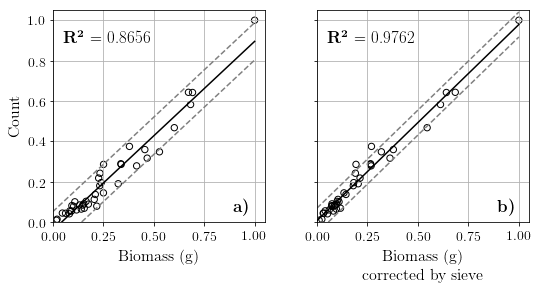

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax[0].scatter(biomass, a_count, marker='o', s=40, facecolors='none', edgecolors='k')
ax[0].set_ylabel('Count', fontsize=fontsize)
ax[0].set_xlabel('Biomass (g)', fontsize=fontsize)

ax[1].scatter(p_count, a_count, marker='o', s=40, facecolors='none', edgecolors='k')
ax[1].set_xlabel('Biomass (g) \n corrected by sieve', fontsize=fontsize)

draw_lines(ax[0], biomass, a_count)
draw_lines(ax[1], p_count, a_count)

draw_rsquared(ax[0], a_count, biomass, fontsize)
draw_rsquared(ax[1], a_count, p_count, fontsize)

draw_sublabel(ax[0], r'\textbf{a)}', fontsize, (0.85, 0.05))
draw_sublabel(ax[1], r'\textbf{b)}', fontsize, (0.85, 0.05))

pretty_axis(ax[0], fontsize)
pretty_axis(ax[1], fontsize)

plt.tight_layout()

In [ ]:
#fname = 'lab_count_from_biomass'
#fig.savefig(fname + '.png')
#fig.savefig(fname + '.eps', format='eps')

# Plot biomass from live coverage

In [15]:
#root_path = '/media/angus/cciw/VOCdevkit/Train-v120-originals/'
#root_path = '/media/angus/cciw/VOCdevkit/Train-v111-originals/JPEGImages/'
#root_path = '/scratch/ssd/gallowaa/cciw/VOCdevkit/Validation-v101-originals/JPEGImages/'
root_path = '/scratch/ssd/gallowaa/cciw/VOCdevkit/Train-v120-originals/'

jpeg_files = glob.glob(root_path + 'JPEGImages/*.jpg')
jpeg_files.sort()

# Should equal 121
print(len(jpeg_files))    

label_path = os.path.join(root_path, 'SegmentationClass')
all_images = glob.glob(osp.join(label_path, '*.png'))
all_images.sort()
print(len(all_images))

152
152


In [16]:
'''
jpeg_files = []

csvfile = 'train-v111-originals-files.csv'
with open(csvfile, 'r') as f:
    spamreader = csv.reader(f, delimiter=',', quotechar='|')
    for row in spamreader:
        jpeg_files.append(row[0])
print(len(jpeg_files))        
'''

"\njpeg_files = []\n\ncsvfile = 'train-v111-originals-files.csv'\nwith open(csvfile, 'r') as f:\n    spamreader = csv.reader(f, delimiter=',', quotechar='|')\n    for row in spamreader:\n        jpeg_files.append(row[0])\nprint(len(jpeg_files))        \n"

In [17]:
lab_targets = np.zeros((len(jpeg_files), 3)) # 0 = biomass, 1 = count, 2 = live coverage

LIVE_COVERAGE = 2

for i in range(len(jpeg_files)):
    
    root_fname = jpeg_files[i].split('/')[-1].split('.')[0].split('_image')[0].split('GLNI_')[1]
    guid = image_df[image_df['Name'].str.contains(root_fname)]['Analysis Index'].astype('int64')
    row = data_df[data_df['Analysis Index'].values == np.unique(guid.values)]
    
    lab_targets[i, BIOMASS_IDX] = row['Biomass'].values
    lab_targets[i, COUNT_IDX] = row['Count'].values
    lab_targets[i, LIVE_COVERAGE] = row['Live Coverage'].values

valid_mask = np.invert(np.isnan(lab_targets[:, 0]))
valid_mask = valid_mask & np.invert(np.isnan(lab_targets[:, 1]))
valid_mask = valid_mask & np.invert(np.isnan(lab_targets[:, 2]))

biomass = lab_targets[:, BIOMASS_IDX][valid_mask]
count = lab_targets[:, COUNT_IDX][valid_mask]
live_coverage = lab_targets[:, LIVE_COVERAGE][valid_mask]

biomass = biomass / biomass.max()
count = count / count.max()
live_coverage = live_coverage / live_coverage.max()

In [18]:
valid_mask.sum()

143

In [19]:
def draw_lines(ax, x, y, xlim):

    x_ = np.linspace(0, xlim)

    A = np.vstack([x, np.ones(len(x))]).T
    (m, c), res, r, s = np.linalg.lstsq(A, y, rcond=-1)
    std = np.sqrt(res[0] / len(y))

    ax.plot(x_, m * x_ + c, 'k', linestyle='-')
    ax.plot(x_, m * x_ + c + 1.96 * std, '--', color='gray')
    ax.plot(x_, m * x_ + c - 1.96 * std, '--', color='gray')

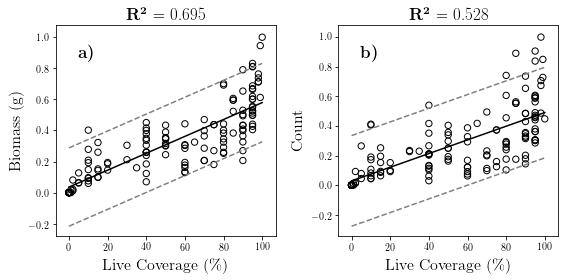

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=False)
ax[0].scatter(live_coverage * 100, biomass, marker='o', s=40, facecolors='none', edgecolors='k')
ax[0].set_xlabel('Live Coverage (\%)', fontsize=fontsize)
ax[0].set_ylabel('Biomass (g)', fontsize=fontsize)
ax[1].scatter(live_coverage * 100, count, marker='o', s=40, facecolors='none', edgecolors='k')
ax[1].set_ylabel('Count', fontsize=fontsize)
ax[1].set_xlabel('Live Coverage (\%)', fontsize=fontsize)
#ax[0].plot(x * 100, y_hat, 'r', linestyle='-')
draw_lines(ax[0], live_coverage*100, biomass, 100)
draw_lines(ax[1], live_coverage*100, count, 100)
ax[0].set_title(r'$\mathbf{R^2}$ = %.3f' % r2_score(biomass, linear_regression(live_coverage, biomass)), fontsize=fontsize + 1)
ax[1].set_title(r'$\mathbf{R^2}$ = %.3f' % r2_score(count, linear_regression(live_coverage, count)), fontsize=fontsize + 1)

draw_sublabel(ax[0], r'\textbf{a)}', fontsize, (.1, .85))
draw_sublabel(ax[1], r'\textbf{b)}', fontsize, (.1, .85))

#pretty_axis(ax[0], fontsize, 105, 1.05)
#pretty_axis(ax[1], fontsize, 105, 1.05)

plt.tight_layout()

fname = 'train_v120_predict_biomass_and_count_from_live_coverage_ab'
#fig.savefig(fname + '.eps', format='eps')
#fig.savefig(fname + '.png', format='png')

In [ ]:
x = count #live_coverage
y = live_coverage
A = np.vstack([x, np.ones(len(x))]).T
(m, c), res, r, s = np.linalg.lstsq(A, y, rcond=-1)
std = np.sqrt(res[0] / len(y))

In [ ]:
#np.sqrt(res) / len(y)

In [ ]:
std

In [ ]:
#np.linalg.lstsq?

In [ ]:
#res

In [ ]:
residuals = biomass - (live_coverage * m + c)
#residuals.mean()

In [ ]:
plt.scatter(live_coverage, residuals)

In [ ]:
#fig, ax = plt.subplots(1, 1)
#power_law_prediction_ax(ax, live_coverage, biomass, 0, 2, fontsize)

In [ ]:
#fig, ax = plt.subplots(1, 1)
#power_law_prediction_ax(ax, live_coverage, count, 0, 2, fontsize)

In [ ]:
from power_law import *

In [ ]:
def pretty_axis(ax, fontsize, xlim, ylim):
    ax.set_ylim(0, ylim)
    ax.set_xlim(0, xlim)
    ax.grid()
    ax.set_aspect('equal')
    ax.tick_params(labelsize=fontsize - 2)

# Live Coverage, Biomass, Count from Segmentation Masks

In [21]:
import cv2
from tqdm import tqdm

In [22]:
pix_ct = []
for i in tqdm(range(len(all_images))):
    im   = cv2.imread(all_images[i])
    _, cts = np.unique(im, return_counts=True) 
    try:
        pix_ct.append(cts[1] / cts.sum())
    except:
        pix_ct.append(0)
pix_ct_np = np.asarray(pix_ct)
pix_ct_np = pix_ct_np / pix_ct_np.max()

100%|██████████| 152/152 [00:26<00:00,  5.64it/s]


In [23]:
x = pix_ct_np[valid_mask]

In [24]:
# v111
'''
mask_y = live_coverage > 0.4
mask_x = x < 0.2
upper_left = mask_x & mask_y
mask_y = live_coverage > 0.38
mask_x = x < 0.1
upper_left |= (mask_x & mask_y)
mask_y = live_coverage < 0.6
mask_x = x > 0.6
bottom_right = mask_x & mask_y
outliers = upper_left | bottom_right
inliers = np.invert(outliers)
'''
# v120
mask_y = live_coverage >= 0.8
mask_x = x < 0.21
upper_left = mask_x & mask_y

mask_y = live_coverage < 0.25
mask_x = x > 0.25
bottom_right = mask_x & mask_y
outliers = upper_left | bottom_right
inliers = np.invert(outliers)

xin = x[inliers]
livein = live_coverage[inliers]
countin = count[inliers]
biomassin = biomass[inliers]

print('Live Coverage R^2 value on %d inliers = %.4f' % (len(xin), r2_score(livein, linear_regression(xin, livein))))
print('Live Coverage R^2 value on %d inliers = %.4f' % (len(x), r2_score(live_coverage, linear_regression(x, live_coverage))))

Live Coverage R^2 value on 126 inliers = 0.6396
Live Coverage R^2 value on 143 inliers = 0.3839


In [ ]:
xin = xin / xin.max()

In [ ]:
xin.max()

In [ ]:
#143 - 126

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4.5), sharex=True, sharey=False)

ax[0].scatter(xin, livein, marker='o', s=40, facecolors='none', edgecolors='k')
ax[0].scatter(x[outliers], live_coverage[outliers], marker='o', s=40, facecolors='none', edgecolors='r')
ax[0].set_ylabel('Live Coverage', fontsize=fontsize)
ax[0].set_title(r'$\mathbf{R^2}$ = %.3f in, %.3f all' % (r2_score(livein, linear_regression(xin, livein)), r2_score(live_coverage, linear_regression(x, live_coverage))), fontsize=fontsize + 1)
draw_lines(ax[0], xin, livein, 1)

ax[1].scatter(xin, biomassin, marker='o', s=40, facecolors='none', edgecolors='k')
ax[1].scatter(x[outliers], biomass[outliers], marker='o', s=40, facecolors='none', edgecolors='r')
ax[1].set_ylabel('Biomass (g)', fontsize=fontsize)
ax[1].set_xlabel('Fraction of Mussel Pixels \n in Segmentation Mask', fontsize=fontsize)
ax[1].set_title(r'$\mathbf{R^2}$ = %.3f in, %.3f all' % (r2_score(xin, linear_regression(xin, biomassin)), r2_score(x, linear_regression(x, biomass))),  fontsize=fontsize + 1)
draw_lines(ax[1], xin, biomassin, 1)

ax[2].scatter(xin, countin, marker='o', s=40, facecolors='none', edgecolors='k')
ax[2].scatter(x[outliers], count[outliers], marker='o', s=40, facecolors='none', edgecolors='r')
ax[2].set_ylabel('Count', fontsize=fontsize)
ax[2].set_title(r'$\mathbf{R^2}$ = %.3f in, %.3f all' % (r2_score(xin, linear_regression(xin, countin)), r2_score(x, linear_regression(x, count))),  fontsize=fontsize + 1)
draw_lines(ax[2], xin, countin, 1)

draw_sublabel(ax[0], r'\textbf{a)}', fontsize, (0.85, 0.05))
draw_sublabel(ax[1], r'\textbf{b)}', fontsize, (0.85, 0.05))
draw_sublabel(ax[2], r'\textbf{c)}', fontsize, (0.85, 0.05))

pretty_axis(ax[0], fontsize, 1.05, 1.05)
pretty_axis(ax[1], fontsize, 1.05, 1.05)
pretty_axis(ax[2], fontsize, 1.05, 1.05)

plt.tight_layout()

if SAVE:
    fname = 'train_v120_livecov_biomass_and_count_from_masks_abc'
    fig.savefig(fname + '.png')
    fig.savefig(fname + '.eps', format='eps')

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=False)

ax[0].scatter(xin, 100*livein, marker='o', s=40, facecolors='none', edgecolors='k')
ax[0].scatter(x[outliers], 100*live_coverage[outliers], marker='o', s=40, facecolors='none', edgecolors='r')
ax[0].set_ylabel('Live Coverage (\%)', fontsize=fontsize)
ax[0].set_xlabel('Fraction of Mussel Pixels \n in Segmentation Mask', fontsize=fontsize)
ax[0].set_title(r'$\mathbf{R^2}$ = %.3f' % r2_score(livein, linear_regression(xin, livein)), fontsize=fontsize + 1)
draw_lines(ax[0], xin, 100*livein, 1)

ax[1].scatter(xin, countin, marker='o', s=40, facecolors='none', edgecolors='k')
ax[1].scatter(x[outliers], count[outliers], marker='o', s=40, facecolors='none', edgecolors='r')
ax[1].set_ylabel('Biomass (g)', fontsize=fontsize)
#ax[1].set_xlabel('Fraction of Mussel Pixels \n (Mask)', fontsize=fontsize)
ax[1].set_xlabel('Fraction of Mussel Pixels \n in Segmentation Mask', fontsize=fontsize)
ax[1].set_title(r'$\mathbf{R^2}$ = %.3f' % r2_score(xin, linear_regression(xin, countin)),  fontsize=fontsize + 1)
draw_lines(ax[1], xin, countin, 1)

draw_sublabel(ax[0], r'\textbf{e)}', fontsize, (0.85, 0.05))
draw_sublabel(ax[1], r'\textbf{f)}', fontsize, (0.85, 0.05))

#pretty_axis(ax[0], fontsize)
pretty_axis(ax[0], fontsize, 1.05, 105)
pretty_axis(ax[1], fontsize, 1.05, 1.05)
#pretty_axis(ax[1], fontsize)

plt.tight_layout()
fname = 'train_v120_live_coverage_and_biomass_from_masks_cd'
#fig.savefig(fname + '.png')
#fig.savefig(fname + '.eps', format='eps')